# Preprocessing and Network Structure



**目录：**
1. VISUAL输入预处理

2. VISUAL输入网络结构

3. RAM输入网络结构

---

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

## 1 VISUAL输入预处理

我们这里的预处理会和paper中的步骤不完全一样，因为paper里也缺少具体操作的细节。这里我们会从原始输入开始，给大家展示每一步操作的

### 1)  查看图像内容，寻找裁剪

首先，我们应该观察图片的内容，确定是否需要裁剪
　

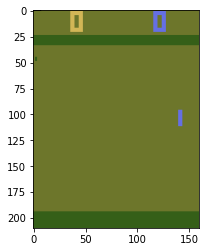

In [2]:
env = gym.make('Pong-v0')
state = env.reset()
plt.imshow(state)

可以看到只有中心部分是游戏信息区域，上面的计分板和边框，下面的边框都是不需要的信息，所以可以进行裁剪，具体裁剪的目标是：

  * 裁剪后图片变为方块状(210, 160, 3) $\longrightarrow$ (160, 160, 3)
  * 裁剪尽可能多的保留中央区域
  
这基本就是一个反复尝试的过程，需要多次尝试才能找到合适的裁剪区域，我自己最后选择的区域是`34:194`, 大家可以调整这个数值看效果，喜欢使用`opencv`的同学也可以使用`opencv`来进行裁剪和downsampleing。此处裁剪后的效果如下:

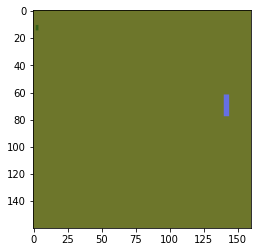

In [3]:
def preprocess(image):
    image = image[34:194, :, :]
    return image

plt.imshow(preprocess(state))

### 2）Grayscale

这一步很简单，其实就是把RGB图像的三个channel取平均值

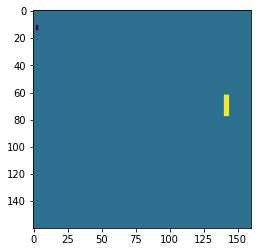

In [4]:
def preprocess(image):
    image = image[34:194, :, :]
    image = np.mean(image, axis=2, keepdims=False) # 这里False是因为Pytorch的channel在最前面
    return image

plt.imshow(preprocess(state))

In [5]:
preprocess(state)

array([[90., 90., 90., ..., 90., 90., 90.],
       [90., 90., 90., ..., 90., 90., 90.],
       [90., 90., 90., ..., 90., 90., 90.],
       ...,
       [90., 90., 90., ..., 90., 90., 90.],
       [90., 90., 90., ..., 90., 90., 90.],
       [90., 90., 90., ..., 90., 90., 90.]])

这里之所以把具体数值输出出来，是因为这也是很重要的一个部分，大家可以看到大部分的数值都是90，很显然这就是“背景”颜色，这个信息显然也是可以去掉的，不过我们暂时不处理，而是放在最后一位来处理

### 3) DownSampling

所谓的DownSampling在这里的操作比较简单，每个方向上直接每两个像素点保留一个就可以了，具体代码如下，可以看到可视化之后并没有感觉有很大的区别，也就是说没有损失很多信息

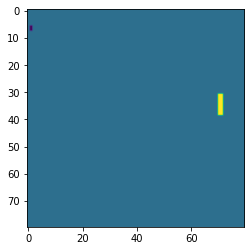

In [6]:
def preprocess(image):
    image = image[34:194, :, :]
    image = np.mean(image, axis=2, keepdims=False) # 这里False是因为Pytorch的channel在最前面
    image = image[::2, ::2]
    return image

plt.imshow(preprocess(state))

### 4) Normalize

处理图像的一个很常见的技巧是Normalize，具体的操作有：
  * 固定mean和std
  * 根据min，max进行缩放
  * 归一化
  
对于我们要处理RGB图像，归一化(/256)显然是很合适的选择，所以直接归一化就好了

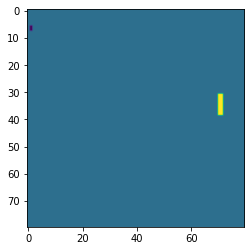

In [7]:
def preprocess(image):
    image = image[34:194, :, :]
    image = np.mean(image, axis=2, keepdims=False) # 这里False是因为Pytorch的channel在最前面
    image = image[::2, ::2]
    image = image/256
    return image

plt.imshow(preprocess(state))

### 5) Remove Background & Padding

现在我们的图像是大小`(80, 80)`的grayscale图片，并且已经完成了归一化，其实这个图像输入就已经可以直接进行使用了，虽然和论文中所给出的`(84, 84)`不完全一样，但微调网络结构总是可以进行的，但是这样微调还是有点麻烦，因为卷积核的kernel size和stride需要重新设计。一个更简单的方法是padding，也就是直接在图片周围补0，补两圈0就会得到`(84, 84)`的图片，并可以直接使用论文中的网络设计。

但直接补0的问题在于，图片中会出现新的“边界”，而这显然是不必要的信息，那么有没有可能让“边界”融入“背景”之中呢？这就需要我们将“背景”的数值也全都变为0。而根据前面的结果，我们知道现在的“背景”是90/256，所以这一步也可以简单完成。

最后，我们可以在这里做padding，也可以在卷积层做，我个人选择了卷积核处再做padding

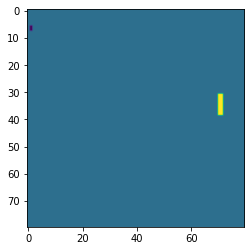

In [8]:
def preprocess(image, constant):
    image = image[34:194, :, :]
    image = np.mean(image, axis=2, keepdims=False) # 这里False是因为Pytorch的channel在最前面
    image = image[::2, ::2]
    image = image/256 
    image = image - constant/256 # 多一个参数constant是因为不同游戏背景色可能不一样
    return image

plt.imshow(preprocess(state, 90))

In [9]:
preprocess(state, 90) # a lot of zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

这样我们就完成了输入信息的预处理部分，并分析了每一步背后的原因，接下来我们讨论具体的网络结构

## 2) VISUAL输入网络结构

这里我们默认同学们知道如何使用Pytorch搭建基本的网络，所以不会进行非常细致的讲解

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Visual_Q_Network(nn.Module):
    '''
    The input of this network should have shape (num_frame, 80, 80)
    '''

    def __init__(self, num_frame, num_action):
        super(Visual_Q_Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_frame, out_channels=16, kernel_size=8, stride=4, padding=2)  # 16, 20, 20
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2)  # 32, 9, 9
        self.fc1 = nn.Linear(32 * 81, 256)
        self.fc2 = nn.Linear(256, num_action)

    def forward(self, image):
        x = F.relu(self.conv1(image))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32 * 81) # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## 3) RAM输入网络结构

RAM输入的网络结构则更加简单，只需要使用fully connected network即可，同样不做过多讲解

In [12]:
class Q_Network(nn.Module):

    def __init__(self, state_size, action_size, hidden=[64, 64]):
        super(Q_Network, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.fc3 = nn.Linear(hidden[1], action_size)

    def forward(self, state):
        x = state
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x